In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 26))
train_y = Variable(torch.sign(torch.cos(train_x.data * (8 * math.pi))))

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class GPClassificationModel(gpytorch.GPModel):
    def __init__(self):
        super(GPClassificationModel,self).__init__(BernoulliLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-6, 6))
        self.grid_covar_module = GridInterpolationKernel(self.covar_module)
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-6,6))
        self.initialize_interpolation_grid(30, grid_bounds=[(0, 1)])
    
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.grid_covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

model = GPClassificationModel()

In [5]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 100))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
        ax.plot(test_x.data.numpy(), pred_labels.data.numpy(), 'b')
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

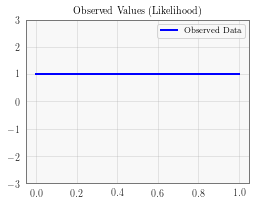

In [6]:
f = plot_model_and_predictions(model, plot_train_data=False)

In [9]:
model.condition(train_x, train_y)

# Find optimal model hyperparameters
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(200):
    optimizer.zero_grad()
    output = model.forward(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/20 - Loss: %.3f   log_lengthscale: %.3f' % (
        i + 1, loss.data[0],
        model.covar_module.log_lengthscale.data.squeeze()[0],
    ))
    optimizer.step()
    
# Set back to eval mode
model.eval()
None

Iter 1/20 - Loss: 120639.906   log_lengthscale: 0.000
Iter 2/20 - Loss: 95397.531   log_lengthscale: -0.100
Iter 3/20 - Loss: 71735.898   log_lengthscale: -0.193
Iter 4/20 - Loss: 56759.375   log_lengthscale: -0.284
Iter 5/20 - Loss: 51305.648   log_lengthscale: -0.370
Iter 6/20 - Loss: 31013.191   log_lengthscale: -0.460
Iter 7/20 - Loss: 28787.914   log_lengthscale: -0.554
Iter 8/20 - Loss: 23169.787   log_lengthscale: -0.650
Iter 9/20 - Loss: 10569.839   log_lengthscale: -0.747
Iter 10/20 - Loss: 19414.557   log_lengthscale: -0.845
Iter 11/20 - Loss: 8855.777   log_lengthscale: -0.945
Iter 12/20 - Loss: 9402.697   log_lengthscale: -1.047
Iter 13/20 - Loss: 7035.566   log_lengthscale: -1.147
Iter 14/20 - Loss: 11255.208   log_lengthscale: -1.245
Iter 15/20 - Loss: 8647.382   log_lengthscale: -1.345
Iter 16/20 - Loss: 9112.208   log_lengthscale: -1.447
Iter 17/20 - Loss: -3432.441   log_lengthscale: -1.548
Iter 18/20 - Loss: 1667.410   log_lengthscale: -1.650
Iter 19/20 - Loss: 3720.6

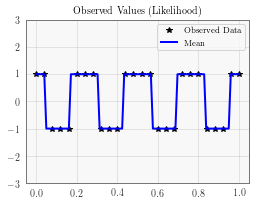

In [10]:
f = plot_model_and_predictions(model)